In [1]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"

from objective_functions import jax_model, objective_model, objective_fit, log_likelihood, Parameter_Index
from new_SLD_utils import DoubleHenyeyGreenstein_SPF, EMP_PSF, DustEllipticalDistribution2PowerLaws, Winnie_PSF
from SLD_ojax import ScatteredLightDisk
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda3/envs/jwst_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.


## Plotting Disks

In [2]:
#Now, plotting disks is made simpler through the new objective function. You need to define four dictionaries, disk_params, spf_params, psf_params, and
#misc_params.

'''
disk_params: (Always use ScatteredLightDisk) (Template for disk_params in objective_functions.py)
    ScatteredLightDisk:
        'accuracy', 'alpha_in', 'alpha_out', 'sma', 'e', 'ksi0', 'gamma', 'beta', 'amin', 'dens_at_r0', 'inclination', 'position_angle', 'x_center',
        'y_center', 'halfNbSlices', 'omega'

spf_params: (Template for spf_params in params field of respective class)
    HenyeyGreenstein_SPF:
        'g'
    DoubleHenyeyGreenstein_SPF:
        'g1', 'g2', 'weight'
    InterpolatedUnivariateSpline_SPF:
        'low_bound', 'up_bound', 'num_knots', 'knot_values'

psf_params: (Template for psf_params in params field of respective class)
    GAUSSIAN_PSF:
        'FWHM', 'xo', 'yo', 'theta', 'offset', 'amplitude'
    EMP_PSF:
        'scale_factor', 'offset'
    WINNIE_PSF:
        winnie_class instance (acts differently from rest because it works differently)

misc_params: (Not tied to any class) (Template for misc_params in objective_functions.py)
    'distance', 'pxInArcsec', 'nx', 'ny', 'flux_scaling'
''' 

"\ndisk_params: (Always use ScatteredLightDisk) (Template for disk_params in objective_functions.py)\n    ScatteredLightDisk:\n        'accuracy', 'alpha_in', 'alpha_out', 'sma', 'e', 'ksi0', 'gamma', 'beta', 'amin', 'dens_at_r0', 'inclination', 'position_angle', 'x_center',\n        'y_center', 'halfNbSlices', 'omega'\n\nspf_params: (Template for spf_params in params field of respective class)\n    HenyeyGreenstein_SPF:\n        'g'\n    DoubleHenyeyGreenstein_SPF:\n        'g1', 'g2', 'weight'\n    InterpolatedUnivariateSpline_SPF:\n        'low_bound', 'up_bound', 'num_knots', 'knot_values'\n\npsf_params: (Template for psf_params in params field of respective class)\n    GAUSSIAN_PSF:\n        'FWHM', 'xo', 'yo', 'theta', 'offset', 'amplitude'\n    EMP_PSF:\n        'scale_factor', 'offset'\n    WINNIE_PSF:\n        winnie_class instance (acts differently from rest because it works differently)\n\nmisc_params: (Not tied to any class) (Template for misc_params in objective_functions.

### Normal Disk

In [3]:
spf_params = DoubleHenyeyGreenstein_SPF.params
psf_params = EMP_PSF.params

disk_params = Parameter_Index.disk_params
disk_params['sma'] = 40
disk_params['inclination'] = 60
disk_params['position_angle'] = 30

img = objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, EMP_PSF)

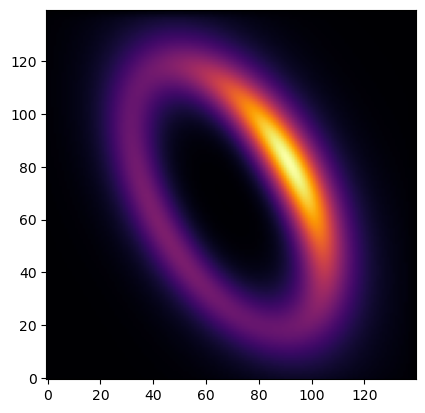

In [4]:
plt.imshow(img, origin='lower', cmap='inferno')

In [11]:
%timeit objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params, ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, EMP_PSF)

1.28 s ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### JWST NIRCam Disk

In [ ]:
#############################################
######### Read in NIRCam model PSFs #########
#############################################

x1 = 0
x2 = 4096
y1 = 0
y2 = 4096

##################### F300M #################
psf_dir = "for_mihir_20241218/F300M/"
psf_suffixes = "_F300M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = np.load(psf_dir+"im_mask_rolls"+psf_suffixes)
psf_inds_rolls = np.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_offsets = np.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = np.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = np.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

nircam_psf_list_f300m = [psfs,psf_inds_rolls,im_mask_rolls,unique_inds]

psf_dir = "for_mihir_20241218/F360M/"
psf_suffixes = "_F360M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = np.load(psf_dir+"im_mask_rolls"+psf_suffixes)
psf_inds_rolls = np.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_offsets = np.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = np.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = np.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

test_parangs = np.unique(np.linspace(-45, 45, 2))

In [ ]:
spf_params = DoubleHenyeyGreenstein_SPF.params
psf_params = Winnie_PSF.init(psfs, psf_inds_rolls, im_mask_rolls, psf_offsets, test_parangs, 46)

disk_params = Parameter_Index.disk_params
disk_params['sma'] = 40
disk_params['inclination'] = 60
disk_params['position_angle'] = 30

img = objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, Winnie_PSF)

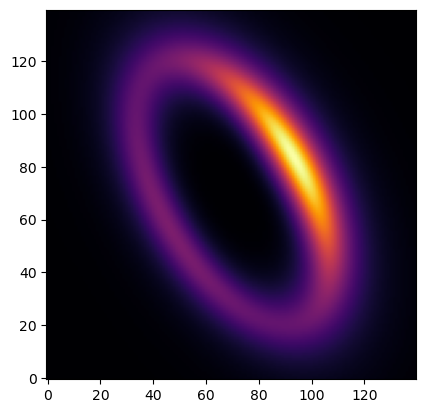

In [20]:
plt.imshow(img, origin='lower', cmap='inferno')

In [10]:
%timeit objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params, ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, Winnie_PSF)

297 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
